In [1]:
import numpy as np
import dihz
import imf
import random
import matplotlib.pyplot as plt
from scipy.integrate import quad
import pandas as pd

The dihz started successfully.


## Calculate DIHZ
Reference: Eggl et al. (2020): [Habitable Zones in Binary Star Systems: A Zoology](https://www.mdpi.com/2075-4434/8/3/65)

The **PHZ** corresponds to a **strict, classical definition of HZ**, while the **AHZ** takes into account the **buffering effects of planetary atmospheres** and **oceans on insolation variability**.
### PHZ: Permanently HZ
$$
PHZ: max(S_I) <= 1 \text{  and  } min(S_O) >= 1
$$

The radiative habitable zones (RHZ) are regions around a binary star system where planets can potentially retain liquid water near their surface. However, due to the changing amount of light a planet receives from the binary star over time, the concept of a "permanently habitable zone" (PHZ) has been introduced to ensure that planets remain within habitable limits at all times. 

### AHZ: Averaged HZ

$$
AHZ: S_I <= 1 \text{  and  } S_O >= 1
$$

The more relaxed concept of an "averaged habitable zone" (AHZ) allows for some parts of the planetary orbit to fall outside the PHZ, as long as the time-averaged insolation remains within habitable limits. 

### DIHZ package
[DIHZ](https://github.com/eggls6/dihz)

The code loops through each binary system and calculates the inner and outer edges of the habitable zone based on the properties of the stars and the binary orbit.

## Monte Carlo Data

In [2]:
# mass primary star
m1 = imf.make_cluster(100000, massfunc='chabrier', mmin=0.1, mmax=1.5)[:100000]
m1 = np.sort(m1)
num_m = len(np.where(m1 < 0.5)[0])
num_fgk = 100000-num_m

# alternative: normal peak at 1

# period
log_mean_m = 3.69
log_std_m = 1.3
log_mean_fgk = 5.03
log_std_fgk = 2.28
log_p_m = np.random.normal(loc=log_mean_m, scale=log_std_m, size=200000)
log_p_fgk = np.random.normal(loc=log_mean_fgk, scale=log_std_fgk, size=200000)
log_p_m = log_p_m[np.where((log_p_m < 4.5) & (log_p_m > 0))]
log_p_fgk = log_p_fgk[np.where((log_p_fgk < 4.5) & (log_p_fgk > 0))]
log_p = np.concatenate((log_p_m[0:num_m],log_p_fgk[0:num_fgk]))
period = 10**log_p

# mass ratio
mu = np.random.uniform(0.2, 0.5, 100000)

m2 = (mu * m1) / (1 - mu)
q_mass = m2/m1

# eccentricity
def generate_eccentricity(logPb):
    sigma_e = 0.2
    mean_e = 0.35
    P_circ = 1.3
    ecc = np.random.normal(loc=mean_e, scale=sigma_e, size=len(logPb))
    ecc[ecc < 0] = 0
    ecc[ecc > 0.8] = 0
    ecc[logPb < P_circ] = 0
    return ecc

e = generate_eccentricity(log_p)

#e = np.random.uniform(0, 0.8, 100000)

# semimajor axis
G = 6.6743e-11   # gravitational constant in m^3 kg^-1 s^-2
solar_mass = 1.98847e30   # mass of the Sun in kg
M_total = solar_mass * (m1 + m2)   # total mass in kg
p_sec = period * 86400   # orbital period in seconds
au = 1.496e11
ab = ((G * M_total * p_sec**2) / (4 * np.pi**2))**(1/3)   # semi-major axis in meters
ab = ab/au

# unit: solar radius / Kelvin / solar luminosity
# Stephan–Boltzmann relation
R1 = m1**0.8
R2 = m2**0.8
T1 = (m1**0.505)*5780
T2 = (m2**0.505)*5780
L1 = (R1**2)*((T1/5780)**4)
L2 = (R2**2)*((T2/5780)**4)
#L1 = m1**3.5
#L2 = m2**3.5

Total cluster mass is 99999.9 (limit was 100000)


### Boundaries of dynamical stability
​
The parameters $m_{\mathrm{A}}, \mu=m_{\mathrm{B}} /\left(m_{\mathrm{A}}+m_{\mathrm{B}}\right), a_b$, and $e_b$, drawn for each binary systems are used to explore which regions of parameter space are consistent with the existence of stable planetary orbits. These authors derived empirical expressions for calculating the  **smallest circumbinary orbit** where fully-interacting particles survive the length of the integration ($10^5$ binary periods). The semi-major axis of such critical planetary orbits are approximated as functions of $e_b$ and $\mu$. 
​
In units of the binary semi-major axis, the semi-major axis of the smallest, stable P-type orbit is:
$$
a_p =(p + q* e_b - r * e_b^2 + s * \mu+t * e_b \mu - u * \mu^2 - v * e_b^2 \mu^2) * {a_b}
$$
​


In [3]:
p = 1.6
q = 5.1
r = -2.22
s = 4.12
t = -4.27
u = -5.09
v = 4.61
ap = (p + q*e + r*(e**2) + s*mu + t*e*mu + u*(mu**2) + v*(e**2)*(mu**2))*ab

### Insolation Threshold

$S A_{I, O}=S_{I, O}\left(T_{e f f}(A)\right) \text { and } S B_{I, O}=S_{I, O}\left(T_{e f f}(B)\right)$

$S_i=a_i+b_iT+c_iT^2+d_iT^3+e_iT^4$

$S_o=a_o+b_oT+c_oT^2+d_oT^3+e_oT^4$

$S_{I,O}$ represent insolation values corresponding to the runaway greenhouse ($S_i$) and the maximum greenhouse ($S_o$) atmospheric collapse limits. $T = T_{eff} − 5780 K$.

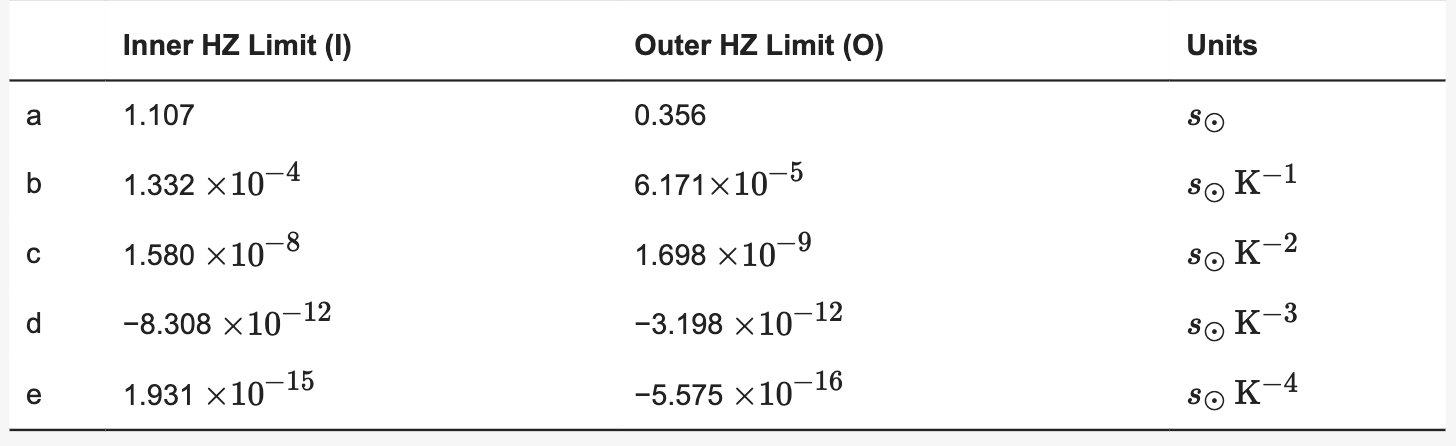

In [4]:
# Create data frame
data = {'m1':m1, 'm2':m2, 'r1':R1, 'r2':R2, 'p':period, 'logP': log_p,'q': q_mass, 'mu':mu, \
        'e': e, 'ab': ab, 'L1': L1,'t1':T1, 'L2':L2, 't2':T2,'ap':ap}
# Create pandas DataFrame
df = pd.DataFrame(data)
# Print DataFrame
print(df.tail())

             m1        m2        r1        r2             p      logP  \
99995  1.499325  0.627366  1.382664  0.688679   3882.716721  3.589136   
99996  1.499337  1.067473  1.382673  1.053624  31520.204261  4.498589   
99997  1.499523  0.519909  1.382810  0.592573      7.930415  0.899296   
99998  1.499692  0.773702  1.382935  0.814440    244.166661  2.387686   
99999  1.499917  1.314500  1.383101  1.244539  11222.012332  4.050071   

              q        mu         e         ab        L1           t1  \
99995  0.418432  0.294996  0.116944   6.217147  4.332542  7091.779311   
99996  0.711964  0.415875  0.197871  26.737647  4.332665  7091.807407   
99997  0.346716  0.257453  0.000000   0.098372  4.334608  7092.251097   
99998  0.515907  0.340329  0.384639   1.005268  4.336386  7092.656831   
99999  0.876382  0.467059  0.489457  13.849770  4.338737  7093.192989   

             L2           t2         ap  
99995  0.184938  4567.471757  17.387318  
99996  1.266638  5973.765308  81.15253

In [5]:
Star_1 = df[['m1', 'r1', 't1', 'L1']].to_dict('list')
Star_2 = df[['m2', 'r2', 't2', 'L2']].to_dict('list')
binary = df[['ab','e']].to_dict('list')

Ndata = len(df['m1'])
phz_inner = np.zeros(Ndata)
phz_outer = np.zeros(Ndata)
ahz_inner = np.zeros(Ndata)
ahz_outer = np.zeros(Ndata)

for i in range(Ndata):
    [PHZ_inner, PHZ_outer] = dihz.circumbinary.PHZ(Star_1['L1'][i],Star_1['t1'][i],Star_1['m1'][i],
                                                   Star_2['L2'][i],Star_2['t2'][i],Star_2['m2'][i],
                                                   binary['ab'][i],binary['e'][i])
    [AHZ_inner, AHZ_outer] = dihz.circumbinary.AHZ(Star_1['L1'][i],Star_1['t1'][i],Star_1['m1'][i],
                                                   Star_2['L2'][i],Star_2['t2'][i],Star_2['m2'][i],
                                                   binary['ab'][i],binary['e'][i])
    phz_inner[i] = PHZ_inner 
    phz_outer[i] = PHZ_outer
    ahz_inner[i] = AHZ_inner
    ahz_outer[i] = AHZ_outer
    
n = len(df.loc[2,:])

df.insert(n, 'ahzi', ahz_inner)
df.insert(n, 'ahzo', ahz_outer)
df.insert(n, 'phzi', phz_inner)
df.insert(n, 'phzo', phz_outer)


df

,m1,m2,r1,r2,p,logP,q,mu,e,ab,L1,t1,L2,t2,ap,phzo,phzi,ahzo,ahzi
0,0.100001,0.098043,0.158491,0.156003,53.140312,1.725424,0.980412,0.495055,0.016009,0.161239,0.000240,1806.887334,0.000223,1788.926652,0.393374,4.899679e-02,2.441525e-03,0.089304,-0.003546
1,0.100002,0.042395,0.158492,0.079772,13502.874686,4.130426,0.423943,0.297724,0.734760,5.794960,0.000240,1806.892144,0.000011,1171.445960,24.400996,4.966050e-08,-2.752115e-09,-0.000241,-0.000026
2,0.100005,0.054861,0.158496,0.098042,1521.434818,3.182253,0.548580,0.354247,0.246815,1.390232,0.000240,1806.923202,0.000027,1334.307449,4.457317,1.457682e-05,-1.124927e-06,-0.001558,-0.000165
3,0.100007,0.032788,0.158498,0.064949,18153.335637,4.258956,0.327860,0.246909,0.641771,6.896537,0.000240,1806.937149,0.000004,1028.882885,28.308713,4.054589e-08,-2.245501e-09,-0.000314,-0.000034
4,0.100007,0.035262,0.158499,0.068841,8251.323560,3.916524,0.352593,0.260679,0.308676,4.102179,0.000240,1806.939970,0.000006,1067.375322,13.853462,4.988687e-07,-2.937572e-08,-0.000582,-0.000063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.499325,0.627366,1.382664,0.688679,3882.716721,3.589136,0.418432,0.294996,0.116944,6.217147,4.332542,7091.779311,0.184938,4567.471757,17.387318,1.595063e+00,4.008075e+02,3.263337,1.973175
99996,1.499337,1.067473,1.382673,1.053624,31520.204261,4.498589,0.711964,0.415875,0.197871,26.737647,4.332665,7091.807407,1.266638,5973.765308,81.152532,1.156119e-01,-2.952658e+00,-4.806765,-0.406276
99997,1.499523,0.519909,1.382810,0.592573,7.930415,0.899296,0.346716,0.257453,0.000000,0.098372,4.334608,7092.251097,0.093682,4154.042824,0.228551,3.181591e+00,1.909618e+00,3.224924,1.863252
99998,1.499692,0.773702,1.382935,0.814440,244.166661,2.387686,0.515907,0.340329,0.384639,1.005268,4.336386,7092.656831,0.395036,5077.588949,3.584650,2.772367e+00,3.669986e+00,3.361006,1.936140


In [6]:
# Determine habitability
def determine_hb(inner,outer,ap): 
    if ap < inner:
        return 'Habitable' # liveable
    elif ap > outer:
        return 'Uninhabitable' # unliveable
    else:
        return 'Partially Habitable'

In [7]:
# reset index
df = df.reset_index(drop=True)
df['PHZ'] = df.apply(lambda x: determine_hb(x.phzi, x.phzo, x.ap), axis=1)
df['AHZ'] = df.apply(lambda x: determine_hb(x.ahzi, x.ahzo, x.ap), axis=1)
#df.insert(19,'AHZ',ahb)
df

,m1,m2,r1,r2,p,logP,q,mu,e,ab,...,t1,L2,t2,ap,phzo,phzi,ahzo,ahzi,PHZ,AHZ
0,0.100001,0.098043,0.158491,0.156003,53.140312,1.725424,0.980412,0.495055,0.016009,0.161239,...,1806.887334,0.000223,1788.926652,0.393374,4.899679e-02,2.441525e-03,0.089304,-0.003546,Uninhabitable,Uninhabitable
1,0.100002,0.042395,0.158492,0.079772,13502.874686,4.130426,0.423943,0.297724,0.734760,5.794960,...,1806.892144,0.000011,1171.445960,24.400996,4.966050e-08,-2.752115e-09,-0.000241,-0.000026,Uninhabitable,Uninhabitable
2,0.100005,0.054861,0.158496,0.098042,1521.434818,3.182253,0.548580,0.354247,0.246815,1.390232,...,1806.923202,0.000027,1334.307449,4.457317,1.457682e-05,-1.124927e-06,-0.001558,-0.000165,Uninhabitable,Uninhabitable
3,0.100007,0.032788,0.158498,0.064949,18153.335637,4.258956,0.327860,0.246909,0.641771,6.896537,...,1806.937149,0.000004,1028.882885,28.308713,4.054589e-08,-2.245501e-09,-0.000314,-0.000034,Uninhabitable,Uninhabitable
4,0.100007,0.035262,0.158499,0.068841,8251.323560,3.916524,0.352593,0.260679,0.308676,4.102179,...,1806.939970,0.000006,1067.375322,13.853462,4.988687e-07,-2.937572e-08,-0.000582,-0.000063,Uninhabitable,Uninhabitable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.499325,0.627366,1.382664,0.688679,3882.716721,3.589136,0.418432,0.294996,0.116944,6.217147,...,7091.779311,0.184938,4567.471757,17.387318,1.595063e+00,4.008075e+02,3.263337,1.973175,Habitable,Uninhabitable
99996,1.499337,1.067473,1.382673,1.053624,31520.204261,4.498589,0.711964,0.415875,0.197871,26.737647,...,7091.807407,1.266638,5973.765308,81.152532,1.156119e-01,-2.952658e+00,-4.806765,-0.406276,Uninhabitable,Uninhabitable
99997,1.499523,0.519909,1.382810,0.592573,7.930415,0.899296,0.346716,0.257453,0.000000,0.098372,...,7092.251097,0.093682,4154.042824,0.228551,3.181591e+00,1.909618e+00,3.224924,1.863252,Habitable,Habitable
99998,1.499692,0.773702,1.382935,0.814440,244.166661,2.387686,0.515907,0.340329,0.384639,1.005268,...,7092.656831,0.395036,5077.588949,3.584650,2.772367e+00,3.669986e+00,3.361006,1.936140,Habitable,Uninhabitable


In [8]:
# Create a boolean mask of the rows that do not satisfy the condition
mask = df['phzo'] > df['phzi']
# Create a new DataFrame containing only the rows that do not satisfy the condition
df = df[mask].copy()
df

,m1,m2,r1,r2,p,logP,q,mu,e,ab,...,t1,L2,t2,ap,phzo,phzi,ahzo,ahzi,PHZ,AHZ
0,0.100001,0.098043,0.158491,0.156003,53.140312,1.725424,0.980412,0.495055,0.016009,0.161239,...,1806.887334,0.000223,1788.926652,0.393374,4.899679e-02,2.441525e-03,0.089304,-0.003546,Uninhabitable,Uninhabitable
1,0.100002,0.042395,0.158492,0.079772,13502.874686,4.130426,0.423943,0.297724,0.734760,5.794960,...,1806.892144,0.000011,1171.445960,24.400996,4.966050e-08,-2.752115e-09,-0.000241,-0.000026,Uninhabitable,Uninhabitable
2,0.100005,0.054861,0.158496,0.098042,1521.434818,3.182253,0.548580,0.354247,0.246815,1.390232,...,1806.923202,0.000027,1334.307449,4.457317,1.457682e-05,-1.124927e-06,-0.001558,-0.000165,Uninhabitable,Uninhabitable
3,0.100007,0.032788,0.158498,0.064949,18153.335637,4.258956,0.327860,0.246909,0.641771,6.896537,...,1806.937149,0.000004,1028.882885,28.308713,4.054589e-08,-2.245501e-09,-0.000314,-0.000034,Uninhabitable,Uninhabitable
4,0.100007,0.035262,0.158499,0.068841,8251.323560,3.916524,0.352593,0.260679,0.308676,4.102179,...,1806.939970,0.000006,1067.375322,13.853462,4.988687e-07,-2.937572e-08,-0.000582,-0.000063,Uninhabitable,Uninhabitable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,1.499133,1.171602,1.382522,1.135074,34.844525,1.542135,0.781520,0.438681,0.142468,0.289667,...,7091.320822,1.774123,6261.260239,0.828595,3.751659e+00,2.342849e+00,3.826422,2.209273,Habitable,Habitable
99994,1.499287,1.389502,1.382636,1.301030,9.854023,0.993614,0.926776,0.480998,0.000000,0.128109,...,7091.687564,3.289656,6824.514415,0.307986,4.224804e+00,2.465393e+00,4.232641,2.449363,Habitable,Habitable
99996,1.499337,1.067473,1.382673,1.053624,31520.204261,4.498589,0.711964,0.415875,0.197871,26.737647,...,7091.807407,1.266638,5973.765308,81.152532,1.156119e-01,-2.952658e+00,-4.806765,-0.406276,Uninhabitable,Uninhabitable
99997,1.499523,0.519909,1.382810,0.592573,7.930415,0.899296,0.346716,0.257453,0.000000,0.098372,...,7092.251097,0.093682,4154.042824,0.228551,3.181591e+00,1.909618e+00,3.224924,1.863252,Habitable,Habitable


In [9]:
np.sum(df['AHZ']=='Habitable')

4820

In [10]:
np.sum(df['PHZ']=='Habitable')

6717

In [11]:
np.sum((df['AHZ']=='Habitable') & (df['PHZ']=='Habitable'))

4551

In [12]:
df_habitable_AHZ = df[(df['AHZ'] == 'Habitable')]
df_parthabitable_AHZ = df[(df['AHZ'] == 'Partially Habitable')]
df_unhabitable_AHZ = df[(df['AHZ'] == 'Uninhabitable')]

df_habitable_PHZ = df[(df['PHZ'] == 'Habitable')]
df_parthabitable_PHZ = df[(df['PHZ'] == 'Partially Habitable')]
df_unhabitable_PHZ = df[(df['PHZ'] == 'Uninhabitable')]

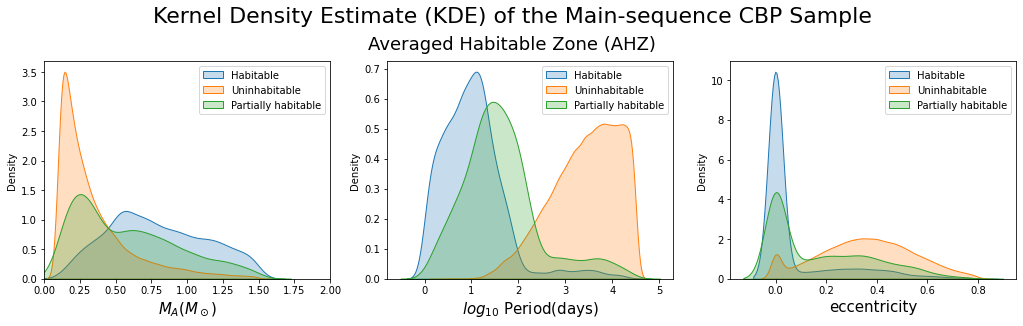

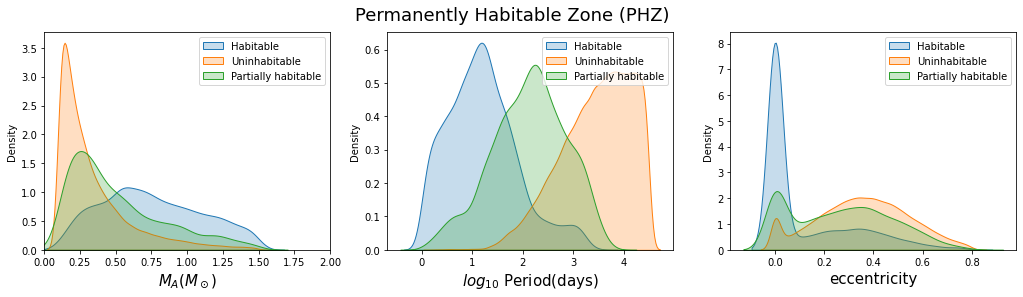

In [16]:
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

# iterate over variables and plot density plots
variables = ['m1', 'logP', 'e']
titles = ['$M_A(M_\odot)$', '$log_{10 }$ Period(days)','eccentricity']
#colors = ['red', 'black', 'red']
for i, var in enumerate(variables):
    sns.kdeplot(data=df_habitable_AHZ[var], ax=axes[i], shade=True, label='Habitable')
    sns.kdeplot(data=df_unhabitable_AHZ[var], ax=axes[i], shade=True, label='Uninhabitable')
    sns.kdeplot(data=df_parthabitable_AHZ[var], ax=axes[i], shade=True, label='Partially habitable')
    axes[0].set_xlim(0,2)
    #axes[1].set_xlim(0,10)
    #axes[2].set_xlim(0,6)
    #axes[3].set_xlim(0,0.8)
    #axes[i].set_title('AHZ')
    axes[i].set_xlabel(titles[i],fontsize=15)
    axes[i].set_ylabel('Density')
    axes[i].legend()
        #sns.move_legend(axes[i], "upper right", bbox_to_anchor=(1.1, 0.8))
plt.subplots_adjust(right=0.8)
plt.suptitle('Kernel Density Estimate (KDE) of the Main-sequence CBP Sample', x=0.45, y=1.07, ha='center', va='top',fontsize=22)
fig.text(0.45, 0.97, 'Averaged Habitable Zone (AHZ)',ha='center', va='top',fontsize=18)
plt.show()


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
# iterate over variables and plot density plots
variables = ['m1', 'logP', 'e']
titles = ['$M_A(M_\odot)$', '$log_{10 }$ Period(days)','eccentricity']
for i, var in enumerate(variables):
    sns.kdeplot(data=df_habitable_PHZ[var], ax=axes[i], shade=True, label='Habitable')
    sns.kdeplot(data=df_unhabitable_PHZ[var], ax=axes[i], shade=True, label='Uninhabitable')
    sns.kdeplot(data=df_parthabitable_PHZ[var], ax=axes[i], shade=True, label='Partially habitable')
    axes[0].set_xlim(0,2)
    #axes[1].set_xlim(0,10)
    #axes[2].set_xlim(0,6)
    #axes[3].set_xlim(0,0.8)
    #axes[i].set_title('PHZ')
    axes[i].set_xlabel(titles[i],fontsize=15)
    axes[i].set_ylabel('Density')
    axes[i].legend()
        #sns.move_legend(axes[i], "upper right", bbox_to_anchor=(1.1, 0.8))
plt.subplots_adjust(right=0.8)
fig.text(0.45, 0.97, 'Permanently Habitable Zone (PHZ)',ha='center', va='top',fontsize=18)
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:254: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<AxesSubplot: xlabel='m1', ylabel='Count'>

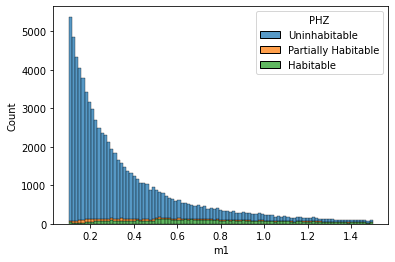

In [17]:
sns.histplot(df, x='m1', hue="PHZ", multiple="stack")

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:254: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<AxesSubplot: xlabel='e', ylabel='Count'>

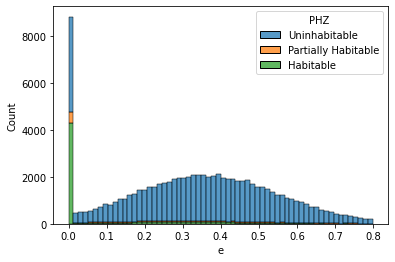

In [18]:
sns.histplot(df, x='e', hue="PHZ", multiple="stack")

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:254: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<AxesSubplot: xlabel='mu', ylabel='Count'>

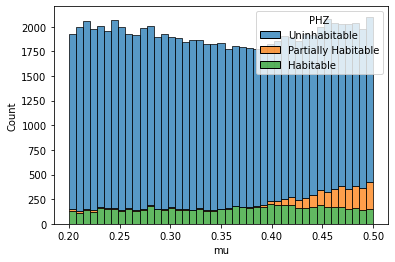

In [19]:
sns.histplot(df, x='mu', hue="PHZ", multiple="stack")